In [79]:
import tensorflow as tf
from keras import Sequential, Model
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Dropout,GlobalAveragePooling2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn as sk
import numpy as np

In [80]:
# Display the version of tensorflow, sklearn, and the GPU
print(f'TensorFlow: {tf.__version__}')
print(f'Scikit-learn: {sk.__version__}')
gpus = tf.config.list_physical_devices('GPU')
print(f'GPUs: {gpus if gpus else "None"}')

TensorFlow: 2.16.1
Scikit-learn: 1.2.2
GPUs: None


## Perform the following steps:
1.	Build a CNN network to classify the boat.
    1.	Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43.

> &nbsp;  
> _Note that the data split is done with the default scikit-learn train_test_split function, it's therefore not keeping consistent ratios across classes._  
> &nbsp;

In [81]:
import os, shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# find all the jpg files one layer deeper in the 'data/source/' folder
files = pd.Series()
folders = pd.Series()
idx = 0
for root, dirs, fs in os.walk('./data/source'):
    for f in fs:
        if (f.endswith('.jpg')):
            files.at[idx] = os.path.join(root, f).replace('\\', '/')
            folders.at[idx] = os.path.basename(root)
            idx += 1

files_train, files_test, folders_train, folders_test = train_test_split(files, folders, test_size=0.2, shuffle = True, random_state=43)

# Create and display a dataframe of file counts by folder for the train and test sets (columns)
df = pd.DataFrame()
df['train'] = folders_train.value_counts()
df['test'] = folders_test.value_counts()
display(df)

# Copy the files to the correct folders
def copy_files(files, dest):
    destpath = f"./data/{dest}"
    if os.path.exists(destpath):
        shutil.rmtree(destpath)
    os.makedirs(destpath)
    for f in files:
        f_target = f.replace('source', dest)
        if (not os.path.exists(os.path.dirname(f_target))):
            os.makedirs(os.path.dirname(f_target))
        shutil.copy(f, f_target)

copy_files(files_train, 'train')
copy_files(files_test, 'test')

,train,test
sailboat,303,86
kayak,162,41
cruise_ship,156,35
gondola,145,48
ferry_boat,56,7
buoy,47,6
paper_boat,27,4
freight_boat,20,3
inflatable_boat,13,3


1. ...

   2. Use Keras ImageDataGenerator to initialize the train generator with validation_split=0.2 and test generator. Generators are required to avoid out of memory issues while training.
   2. Both generators will be initialized with data normalization. _(Hint: rescale=1./255)._
   2. Load train, validation and test dataset in batches of 32 using the generators initialized in the above step.

> &nbsp;  
> _Note: While a batch size of 32 makes sense for stabilizing backprop feedback into the layers, there's no reason to do that for the test dataset.  To retain the ability to look at individual test samples._  
> &nbsp;

In [82]:
from random import shuffle


def create_generators(train_dir: str, test_dir: str, val_split: float, image_size: int):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8,1.2],
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=val_split)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=43)
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=43)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical',
        shuffle=False,
        seed=43)
    return (train_generator, validation_generator, test_generator)

train_generator, validation_generator, test_generator = create_generators('./data/train', './data/test', 0.2, 150)

Found 746 images belonging to 9 classes.
Found 183 images belonging to 9 classes.
Found 233 images belonging to 9 classes.


1. ...

    5.	Build a CNN network using Keras with the following layers
        - Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
        - Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
        - GLobalAveragePooling2D layer
        - Dense layer with 128 neurons and activation relu
        - Dense layer with 128 neurons and activation relu
        - Dense layer with 9 neurons and activation softmax.

In [83]:
cnn = Sequential()

cnn.add(Input(shape=(150, 150, 3)))
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
cnn.add(MaxPooling2D((2, 2), strides=2, padding='valid'))
cnn.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
cnn.add(MaxPooling2D((2, 2), strides=2, padding='valid'))
cnn.add(GlobalAveragePooling2D())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(9, activation='softmax'))

1. ...

    6. Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.

In [84]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,041 (125.16 KB)

 Trainable params: 32,041 (125.16 KB)

 Non-trainable params: 0 (0.00 B)

1. ...  

    7. Train the model for 20 epochs and plot training loss and accuracy against epochs.
    7. Evaluate the model on test images and print the test loss and accuracy.

> &nbsp;  
> _Note: the test loss and accuracy are included in the plots below_  
> &nbsp;

In [85]:
import warnings
warnings.filterwarnings("ignore")

history_cnn = cnn.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 999ms/step - accuracy: 0.2651 - loss: 2.0833 - precision: 0.2085 - recall: 0.0064 - val_accuracy: 0.3279 - val_loss: 1.8039 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - accuracy: 0.3360 - loss: 1.8597 - precision: 0.2320 - recall: 0.0037 - val_accuracy: 0.3279 - val_loss: 1.7760 - val_precision: 1.0000 - val_recall: 0.0109
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 562ms/step - accuracy: 0.3305 - loss: 1.8244 - precision: 0.3400 - recall: 0.0019 - val_accuracy: 0.3279 - val_loss: 1.8005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 484ms/step - accuracy: 0.3211 - loss: 1.8225 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3279 - val_loss: 1.7730 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 483ms/step - accuracy: 0.3249 - loss: 1.8156 - precision: 0.6300 - recall: 0.0037 

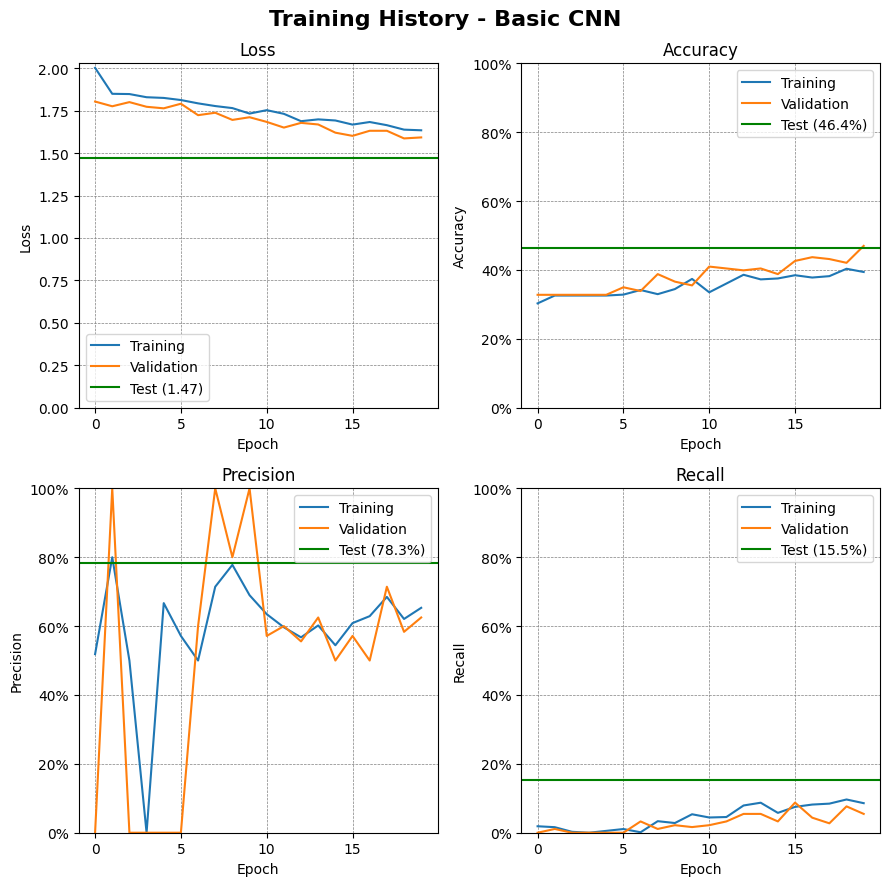

In [86]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def training_subplot(hist, metric: str, plotnum: int, lim = None, test_val = None):
    sp = plt.subplot(2, 2, plotnum)
    plt.plot(hist.history[metric], label='Training')
    plt.plot(hist.history['val_' + metric], label='Validation')
    if (test_val is not None):
        test_lbl = 'Test ' + (f'({test_val:.1%})' if (lim == 1) else f'({test_val:.2f})')
        plt.axhline(y=test_val, label=test_lbl, color='green', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, lim)
    if (lim == 1):
        sp.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='grey')
    plt.title(metric.capitalize())

def training_plot(hist, model, generator, title='Training History'):
    eval = model.evaluate(generator, verbose=0, return_dict=True)
    # Plot the training history (loss and accuracy) in two subplots
    plt.figure(figsize=(9, 9))
    plt.suptitle(title, fontsize=16, fontweight='bold')
    training_subplot(hist, 'loss', 1, test_val=eval['loss'] if eval else None)
    training_subplot(hist, 'accuracy', 2, 1, test_val=eval['accuracy'] if eval else None)
    training_subplot(hist, 'precision', 3, 1, test_val=eval['precision'] if eval else None)
    training_subplot(hist, 'recall', 4, 1, test_val=eval['recall'] if eval else None)
    plt.tight_layout()
    plt.show()

training_plot(history_cnn, cnn, test_generator, "Training History - Basic CNN")

233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


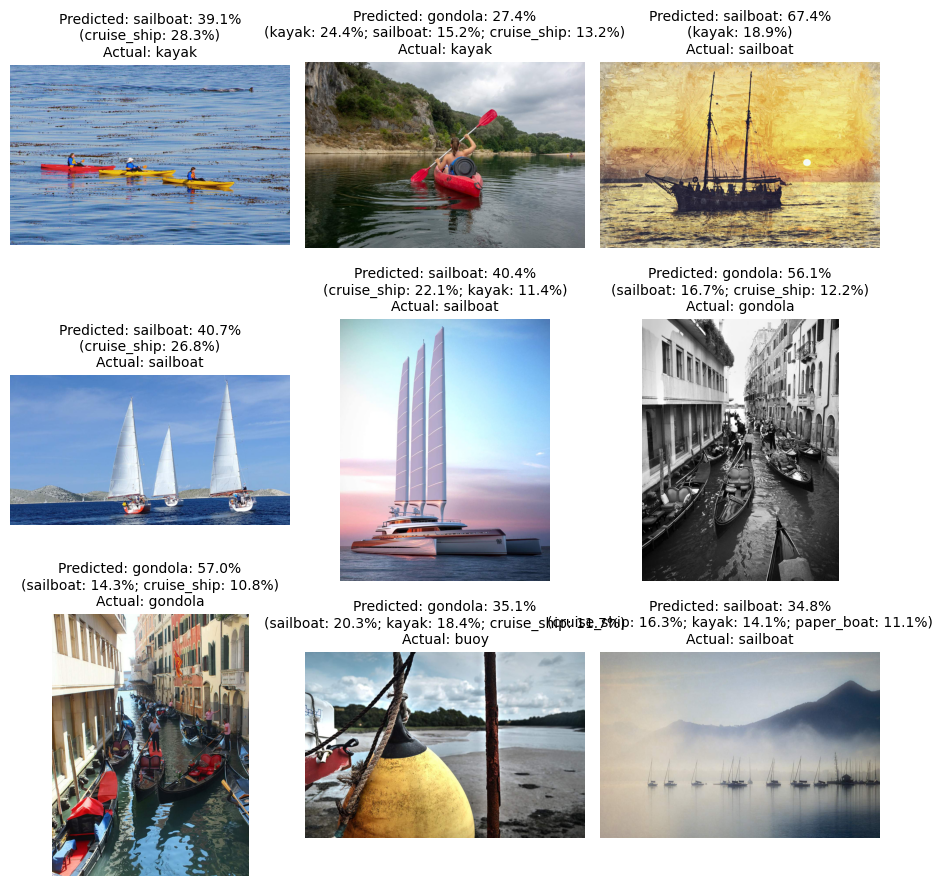

In [87]:
def predict_and_display(model: Model, generator: ImageDataGenerator, path: str):
    pred = model.predict(generator)
    class_names = [k for k in generator.class_indices.keys()]
    if not path.endswith('/'):
        path += '/'

    plt.figure(figsize=(9,9))
    picked_image_indexes = []
    for i in range(9):
        # pick a random image index that hasn't been picked yet
        idx = None
        while (idx is None or idx in picked_image_indexes):
            idx = np.random.randint(0, len(generator.filenames))
        picked_image_indexes.append(idx)
        # Show top probability(ies) greater than 10%
        top_preds = [(str(k), f"{round(float(v),3):.1%}") for k, v in zip(generator.class_indices.keys(), pred[idx]) if v >= 0.1]
        top_preds.sort(key=lambda x: x[1], reverse=True)
        top_pred_str = f"{top_preds[0][0]}: {top_preds[0][1]}"
        if (len(top_preds) > 1):
            top_pred_str += "\n(" + "; ".join([f"{k}: {v}" for k, v in top_preds[1:]]) + ")" 
        # Show image
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(f"{path}{generator.filenames[idx]}"))
        plt.title(f"Predicted: {top_pred_str}\nActual: {class_names[generator.labels[idx]]}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

predict_and_display(cnn, test_generator, "./data/test")

1. ...  

    9. Plot heatmap of the confusion matrix and print classification report  

233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


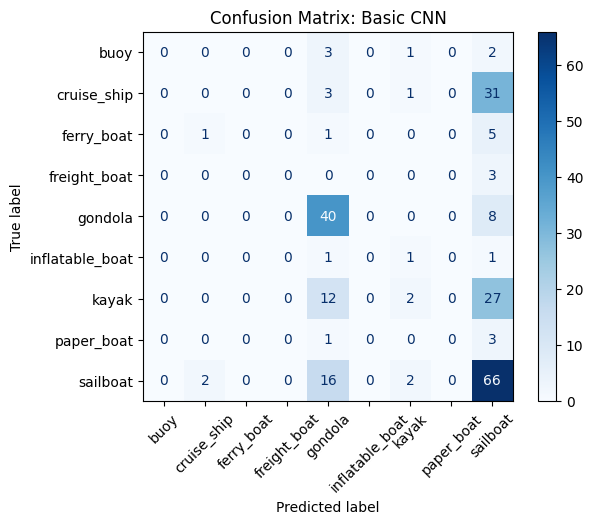

                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00         6
    cruise_ship       0.00      0.00      0.00        35
     ferry_boat       0.00      0.00      0.00         7
   freight_boat       0.00      0.00      0.00         3
        gondola       0.52      0.83      0.64        48
inflatable_boat       0.00      0.00      0.00         3
          kayak       0.29      0.05      0.08        41
     paper_boat       0.00      0.00      0.00         4
       sailboat       0.45      0.77      0.57        86

       accuracy                           0.46       233
      macro avg       0.14      0.18      0.14       233
   weighted avg       0.32      0.46      0.36       233



In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def confusion_matrix_and_classification_report(model: Model, generator: keras.preprocessing.image.DirectoryIterator, title: str):
    # Generate predictions
    test_pred = model.predict(generator)
    predicted_labels = test_pred.argmax(axis=1)
    class_names = generator.class_indices.keys()
    # Compute the confusion matrix
    cm = confusion_matrix(generator.labels, predicted_labels)
    # Plot the confusion matrix
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_names)
    cm_display.plot(cmap='Blues', values_format='d', xticks_rotation=45)
    plt.title('Confusion Matrix: ' + title)
    plt.show()
    # Display the classification report
    print(classification_report(generator.labels, predicted_labels, target_names=class_names))

confusion_matrix_and_classification_report(cnn, test_generator, 'Basic CNN')


2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.  
    1. Split the dataset into train and test datasets in the ration 70:30, with shuffle and random state=1. 

In [89]:
files_lm_train, files_lm_test, folders_lm_train, folders_lm_test = train_test_split(files, folders, test_size=0.3, shuffle = True, random_state=1)

# Create and display a dataframe of file counts by folder for the train and test sets (columns)
df = pd.DataFrame()
df['lm_train'] = folders_lm_train.value_counts()
df['lm_test'] = folders_lm_test.value_counts()
display(df)

# Copy the files to the correct folders
copy_files(files_lm_train, 'lm_train')
copy_files(files_lm_test, 'lm_test')

,lm_train,lm_test
sailboat,275,114
kayak,148,55
gondola,137,56
cruise_ship,129,62
ferry_boat,48,15
buoy,37,16
paper_boat,18,13
freight_boat,13,10
inflatable_boat,8,8


2. ...  

    2. Use Keras ImageDataGenerator to initialize the train generator with validation_split=0.2 and test generator. Generators are required to avoid out-of-memory issues while training.  
    2. Both generators will be initialized with data normalization. _(Hint: rescale=1./255)._  
    2. Load train, validation and test datasets in batches of 32 using the generators initialized in the above step.

> &nbsp;  
> Note: MobileNetV2 uses an image size of 224, so this value is used here instead of the 150 setting used earlier.  
> &nbsp;  

In [90]:
train_lm_generator, validation_lm_generator, test_lm_generator = create_generators('./data/lm_train', './data/lm_test', 0.2, 224)

Found 655 images belonging to 9 classes.
Found 158 images belonging to 9 classes.
Found 349 images belonging to 9 classes.


2. ...  

    5. Build a CNN network using Keras with the following layers.  
        * Load MobileNetV2 - Light Model as the first layer _(Hint: Keras API Doc)_
        * GLobalAveragePooling2D layer
        * Dropout(0.2)
        * Dense layer with 256 neurons and activation relu
        * BatchNormalization layer
        * Dropout(0.1)
        * Dense layer with 128 neurons and activation relu
        * BatchNormalization layer
        * Dropout(0.1)
        * Dense layer with 9 neurons and activation softmax


In [91]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

lm_cnn = Sequential()
lm_cnn.add(base_model)
lm_cnn.add(GlobalAveragePooling2D())
lm_cnn.add(Dropout(0.2))
lm_cnn.add(Dense(256, activation='relu'))
lm_cnn.add(BatchNormalization())
lm_cnn.add(Dropout(0.1))
lm_cnn.add(Dense(128, activation='relu'))
lm_cnn.add(BatchNormalization())
lm_cnn.add(Dropout(0.1))
lm_cnn.add(Dense(9, activation='softmax'))

2. ...  

    6.	Compile the model with Adam optimizer, categorical_crossentropy loss, and metrics accuracy, Precision, and Recall.

In [92]:
lm_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

lm_cnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

2. ...  

    7. Train the model for 50 epochs and Early stopping while monitoring validation loss.  

> &nbsp;  
> _Note: I'm assuming that this means_ **at most** _50 epochs of training with early stopping to occur before these 50 epochs (if at all)_  
> &nbsp;

In [93]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', verbose=1, start_from_epoch=25)

In [94]:
import warnings
warnings.filterwarnings("ignore")

history_lm_cnn = lm_cnn.fit(train_lm_generator, validation_data=validation_lm_generator, epochs=50, callbacks=[early_stopping])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3659 - loss: 2.0911 - precision: 0.5052 - recall: 0.2528 - val_accuracy: 0.8228 - val_loss: 0.7375 - val_precision: 0.9200 - val_recall: 0.7278
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 737ms/step - accuracy: 0.7882 - loss: 0.6864 - precision: 0.8666 - recall: 0.7200 - val_accuracy: 0.8038 - val_loss: 0.6314 - val_precision: 0.8692 - val_recall: 0.7152
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 759ms/step - accuracy: 0.8538 - loss: 0.4617 - precision: 0.8961 - recall: 0.8084 - val_accuracy: 0.8418 - val_loss: 0.5337 - val_precision: 0.8978 - val_recall: 0.7785
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 747ms/step - accuracy: 0.8877 - loss: 0.3328 - precision: 0.9369 - recall: 0.8520 - val_accuracy: 0.8734 - val_loss: 0.4467 - val_precision: 0.9236 - val_recall: 0.8418
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 756ms/step - accuracy: 0.8789 - loss: 0.3447 - precision: 0.8960 - recall: 0.8513 - val_accuracy: 0.8924 - val_loss: 

2. ...  

    8. Evaluate the model on test images and print the test loss and accuracy.  

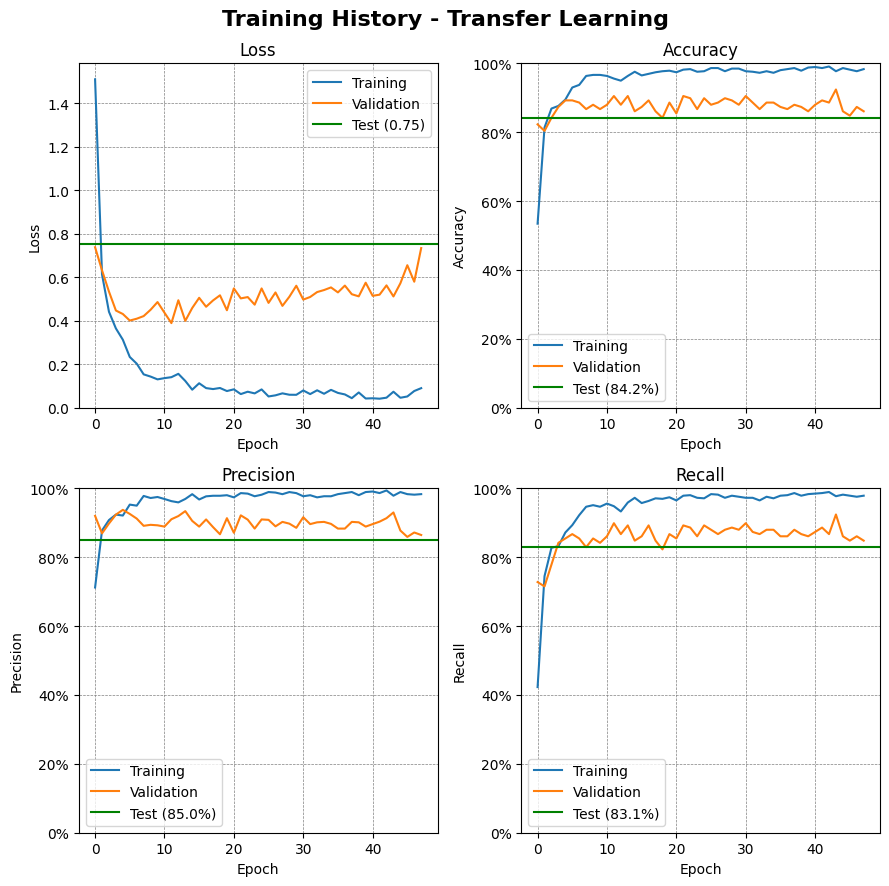

In [95]:
training_plot(history_lm_cnn, lm_cnn, test_lm_generator, "Training History - Transfer Learning")

349/349 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


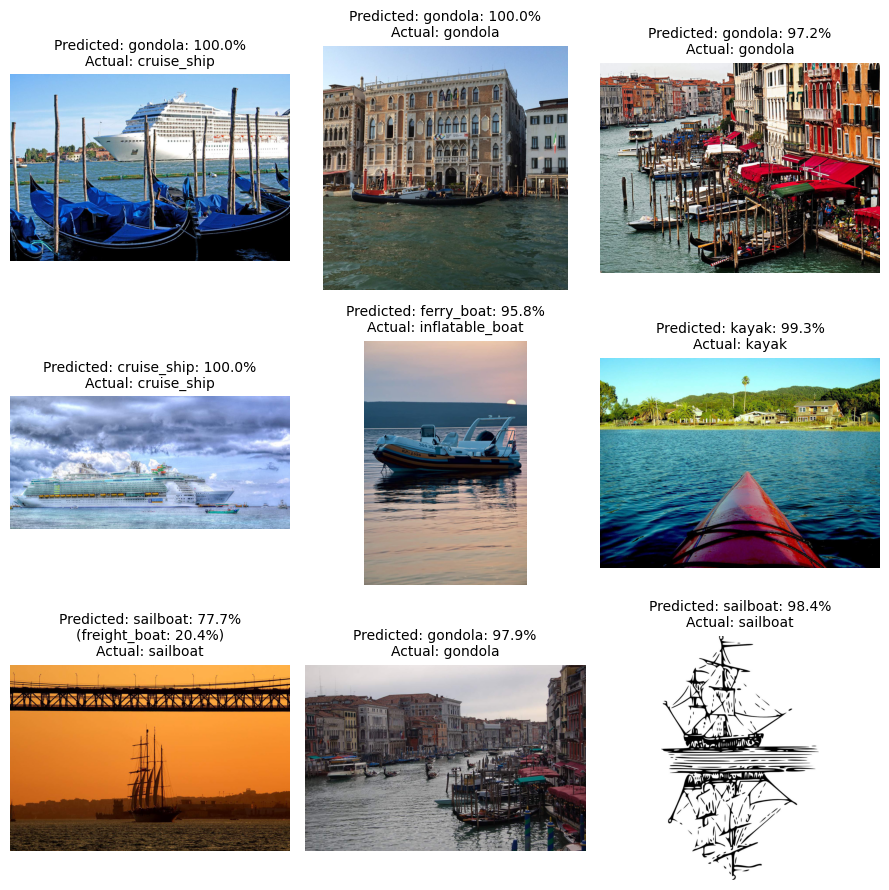

In [96]:
predict_and_display(lm_cnn, test_lm_generator, "./data/lm_test")


349/349 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


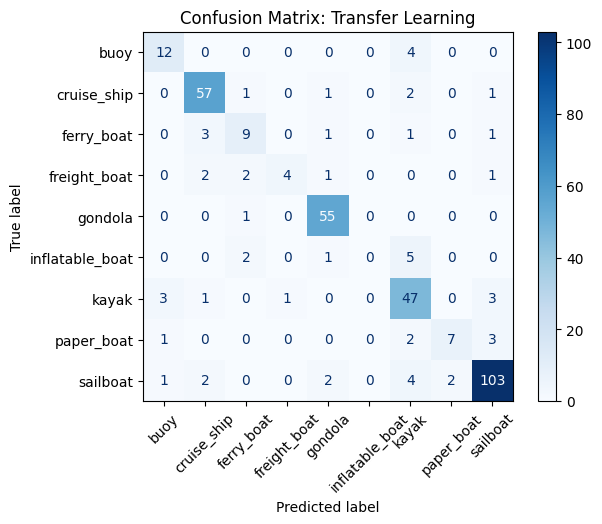

                 precision    recall  f1-score   support

           buoy       0.71      0.75      0.73        16
    cruise_ship       0.88      0.92      0.90        62
     ferry_boat       0.60      0.60      0.60        15
   freight_boat       0.80      0.40      0.53        10
        gondola       0.90      0.98      0.94        56
inflatable_boat       0.00      0.00      0.00         8
          kayak       0.72      0.85      0.78        55
     paper_boat       0.78      0.54      0.64        13
       sailboat       0.92      0.90      0.91       114

       accuracy                           0.84       349
      macro avg       0.70      0.66      0.67       349
   weighted avg       0.82      0.84      0.83       349



In [97]:
confusion_matrix_and_classification_report(lm_cnn, test_lm_generator, 'Transfer Learning')


2. ...  

    9. Plot Train loss Vs Validation loss and Train accuracy Vs Validation accuracy.


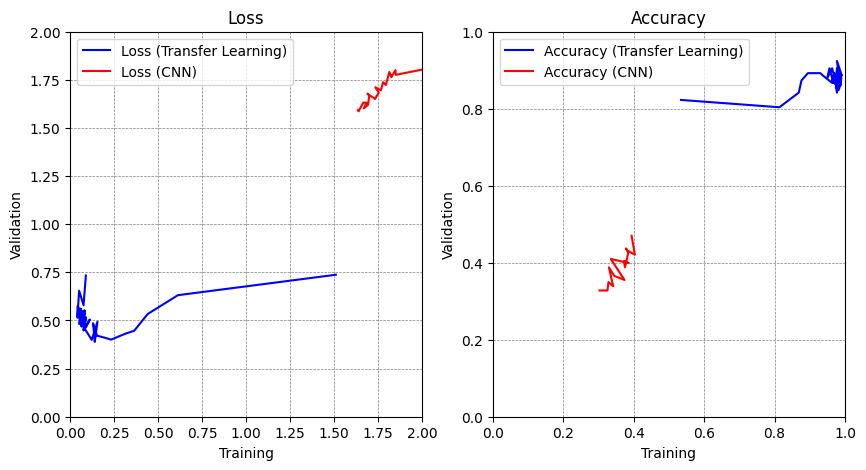

In [111]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lm_cnn.history['loss'], history_lm_cnn.history['val_loss'], label='Loss (Transfer Learning)', color='blue', marker=None)
plt.plot(history_cnn.history['loss'], history_cnn.history['val_loss'], label='Loss (CNN)', color='red', marker=None)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.title('Loss')
plt.xlabel('Training')
plt.ylabel('Validation')
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='grey')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lm_cnn.history['accuracy'], history_lm_cnn.history['val_accuracy'], label='Accuracy (Transfer Learning)', color='blue', marker=None)
plt.plot(history_cnn.history['accuracy'], history_cnn.history['val_accuracy'], label='Accuracy (CNN)', color='red', marker=None)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Accuracy')
plt.xlabel('Training')
plt.ylabel('Validation')
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='grey')
plt.legend()

plt.show()


3.	Compare the results of both models built in steps 1 and 2 and state your observations.

> &nbsp;
> 